# Predykcja liczby zamówień
## Michał Hetmańczuk

## Przygotowanie danych:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix

In [2]:
dataset = pd.read_csv('predykcja.csv', sep=';')
dataset.head()

,DATA,zamowienia,wyprzedaż
0,01.01.2018,100.0,NaN
1,02.01.2018,94.0,NaN
2,03.01.2018,118.0,1.0
3,04.01.2018,114.0,1.0
4,05.01.2018,122.0,1.0


Wstępnie przetworzono zbiór danych do analizowalnej postaci.

In [3]:
print(dataset.info())
dataset.dropna(subset=['DATA', 'zamowienia'], inplace=True)
dataset['DATA'] = pd.to_datetime(dataset['DATA'])
dataset['wyprzedaż'].fillna(0, inplace=True)
dataset['wyprzedaż'] = dataset['wyprzedaż'].astype('bool')
dataset['zamowienia'] = dataset['zamowienia'].astype('int64')
print(dataset.info())
print(dataset.head())
print(dataset['wyprzedaż'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1820 entries, 0 to 1819
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATA        731 non-null    object 
 1   zamowienia  731 non-null    float64
 2   wyprzedaż   73 non-null     float64
dtypes: float64(2), object(1)
memory usage: 42.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 731 entries, 0 to 730
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATA        731 non-null    datetime64[ns]
 1   zamowienia  731 non-null    int64         
 2   wyprzedaż   731 non-null    bool          
dtypes: bool(1), datetime64[ns](1), int64(1)
memory usage: 17.8 KB
None
        DATA  zamowienia  wyprzedaż
0 2018-01-01         100      False
1 2018-02-01          94      False
2 2018-03-01         118       True
3 2018-04-01         114       True
4 2018-05-01         122       True

Wydzielono zbiór danych do ostatecznej ewaluacji modelu w celu uniknięcia 'data snooping bias'.

In [4]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [5]:
for train_index, test_index in split.split(dataset, dataset['wyprzedaż']):
    train_set = dataset.loc[train_index]
    test_set = dataset.loc[test_index]

## Eksploracja danych

In [6]:
dataset = train_set.copy()

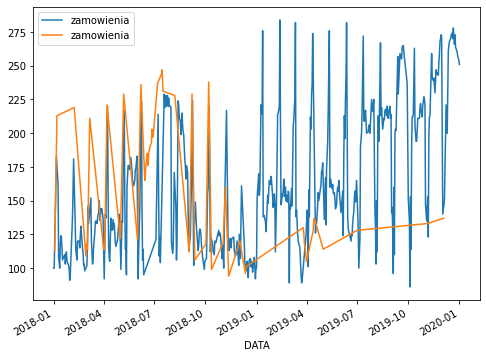

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
bp = dataset.groupby('wyprzedaż').plot(x='DATA', y='zamowienia', ax=ax)

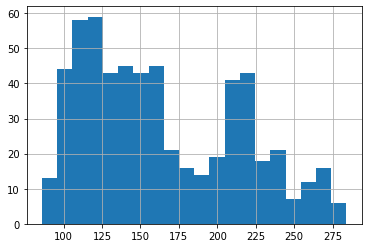

In [8]:
dataset['zamowienia'].hist(bins=20)

Zaobserwowano okresowość we wzroście liczby zamówień. Rozkład liczby zamówień jest wielomodalny (3 ekstrema lokalne).

### Poszukiwanie jak najlepszej reprezentacji danych

Data zostanie przedstawiona za pomocą trzech zmiennych: rok, miesiąc, dzień miesiąca. Ponaddto wyekstrahowano cechy daty które mogą mieć wpływ na liczbę zamówień: dzień roku, tydzień roku, dzień tygodnia, kwartał, czy początek/koniec miesiąca, czy początek/koniec kwartału, czy weekend.

In [9]:
df = dataset.copy()
df['year'] = pd.DatetimeIndex(df['DATA']).year
df['month'] = pd.DatetimeIndex(df['DATA']).month
df['day'] = pd.DatetimeIndex(df['DATA']).day
df['dayofyear'] = pd.DatetimeIndex(df['DATA']).dayofyear
df['weekofyear'] = pd.DatetimeIndex(df['DATA']).weekofyear
df['weekday'] = pd.DatetimeIndex(df['DATA']).weekday
df['quarter'] = pd.DatetimeIndex(df['DATA']).quarter
df['is_month_start'] = pd.DatetimeIndex(df['DATA']).is_month_start
df['is_month_end'] = pd.DatetimeIndex(df['DATA']).is_month_end
df['is_quarter_start'] = pd.DatetimeIndex(df['DATA']).is_quarter_start
df['is_quarter_end'] = pd.DatetimeIndex(df['DATA']).is_quarter_end
df['is_weekend'] = df['weekday'].isin([4,5,6])


<ipython-input-9-d2cffb37604e>:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['weekofyear'] = pd.DatetimeIndex(df['DATA']).weekofyear


In [10]:
df

,DATA,zamowienia,wyprzedaż,year,month,day,dayofyear,weekofyear,weekday,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_weekend
669,2019-01-11,214,False,2019,1,11,11,2,4,1,False,False,False,False,True
483,2019-04-29,172,False,2019,4,29,119,18,0,2,False,False,False,False,False
642,2019-05-10,218,False,2019,5,10,130,19,4,2,False,False,False,False,True
375,2019-11-01,147,False,2019,11,1,305,44,4,4,True,False,False,False,True
405,2019-10-02,143,False,2019,10,2,275,40,2,4,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,2019-03-22,96,False,2019,3,22,81,12,4,1,False,False,False,False,True
714,2019-12-16,270,False,2019,12,16,350,51,0,4,False,False,False,False,False
519,2019-04-06,138,False,2019,4,6,96,14,5,2,False,False,False,False,True
501,2019-05-17,159,False,2019,5,17,137,20,4,2,False,False,False,False,True


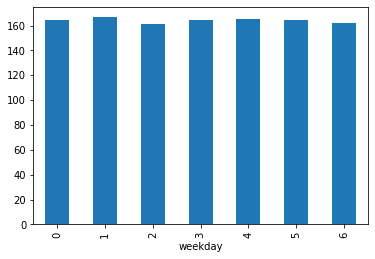

In [11]:
df.groupby('weekday')['zamowienia'].mean().plot.bar()

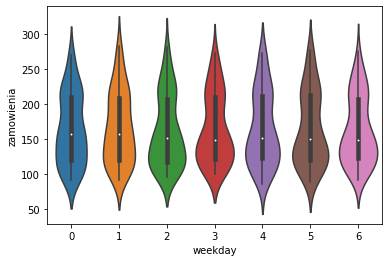

In [12]:
sns.violinplot(x="weekday", y="zamowienia", data=df)

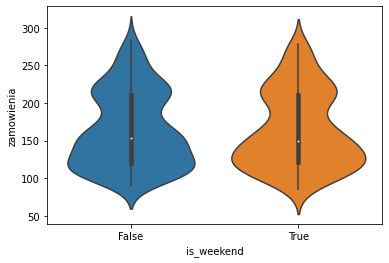

In [13]:
sns.violinplot(x="is_weekend", y="zamowienia", data=df)

Wniosek: dzień tygodnia nie ma znaczącego wpływu na liczbę zamówień

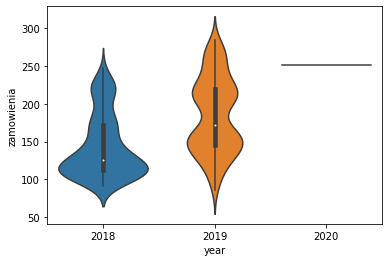

In [14]:
sns.violinplot(x="year", y="zamowienia", data=df)

Widać wyraźną poprawę w liczbnie zamówień w 2019, względem roku 2018. 

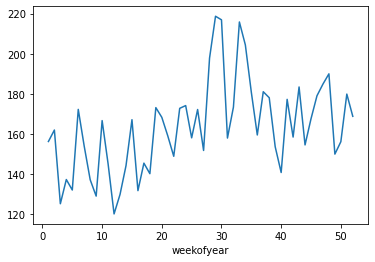

In [15]:
df.groupby('weekofyear')['zamowienia'].mean().plot()

Wynik liczby sprzedaży na przestrzeni tygodni roku również przejawia tendencję okresową. Wydaje się, iż lepsze wyniki zostają osiągnięte w okresie jesienno-zimowym (zwłaszcza wczesna jesień).

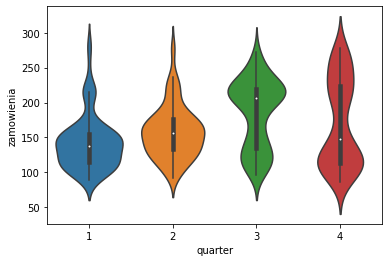

In [16]:
sns.violinplot(x="quarter", y="zamowienia", data=df)

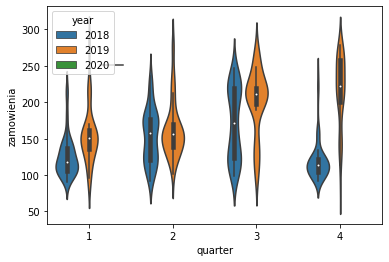

In [17]:
sns.violinplot(x="quarter", y="zamowienia", hue='year', data=df)

Widać wyraźną zależność liczby sprzedaży od kwartału - ponownie wniosek o lepszych wynikach w okresie jesiennym (zimowym tylko dla 2019 roku).

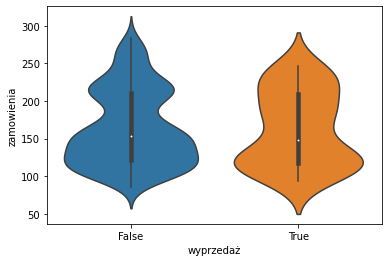

In [18]:
sns.violinplot(x="wyprzedaż", y="zamowienia", data=df)

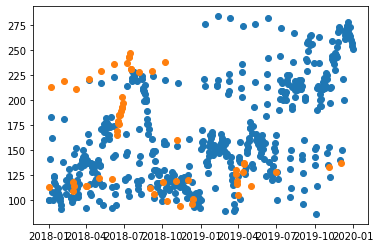

In [19]:
groups = df.groupby('wyprzedaż')
for name, group in groups:
    plt.plot(group["DATA"], group["zamowienia"], marker="o", linestyle="", label=name)

Widać wpływ wyprzedaży na rozkład liczby zamówień, jednak wydaje się on mniejszy niż przypuszczano.

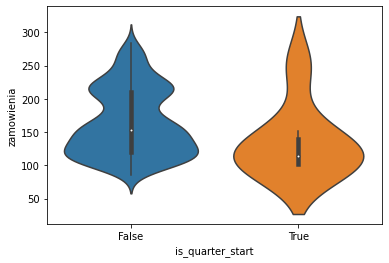

In [20]:
sns.violinplot(x="is_quarter_start", y="zamowienia", data=df)

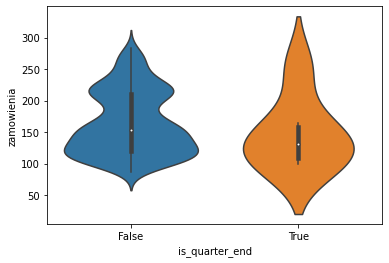

In [21]:
sns.violinplot(x="is_quarter_end", y="zamowienia", data=df)

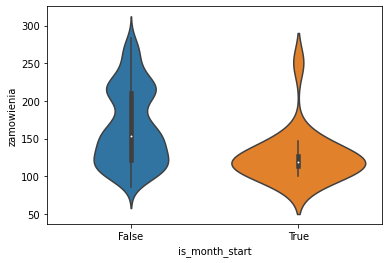

In [22]:
sns.violinplot(x="is_month_start", y="zamowienia", data=df)

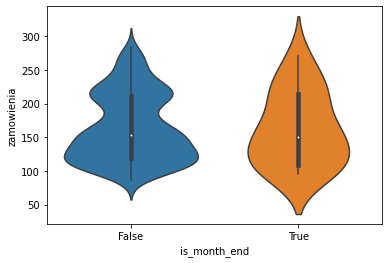

In [23]:
sns.violinplot(x="is_month_end", y="zamowienia", data=df)

Można zauważyć, iż wyniki są zależnego od tego czy próbka pochodzi z początku, końca czy środka okresu (miesiąc, kwartał).

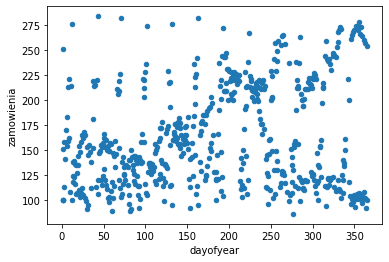

In [24]:
df.plot(kind='scatter', x='dayofyear', y='zamowienia')

Widać pewną (lecz słabą) zależność zagęszczenia próbek w zależności od dnia roku.

In [25]:
df.corr()['zamowienia']

zamowienia          1.000000
wyprzedaż          -0.011642
year                0.417340
month               0.219516
day                 0.120629
dayofyear           0.228442
weekofyear          0.227573
weekday            -0.008993
quarter             0.235518
is_month_start     -0.133342
is_month_end       -0.008429
is_quarter_start   -0.062253
is_quarter_end     -0.033427
is_weekend          0.000186
Name: zamowienia, dtype: float64

# Implementacja modelu

## Klasa transformująca dane do formatu analizowalnego przez model

In [26]:
import sklearn
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class DateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, date_attr, sale_attr):
        self.date_attr = date_attr
        self.sale_attr = sale_attr
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        df = X.copy()
        df['year'] = pd.DatetimeIndex(df[self.date_attr]).year
        df['month'] = pd.DatetimeIndex(df[self.date_attr]).month
        df['month'] = df['month'].astype(pd.CategoricalDtype(categories=range(1,13)))
        df['day'] = pd.DatetimeIndex(df[self.date_attr]).day
        df['dayofyear'] = pd.DatetimeIndex(df[self.date_attr]).dayofyear
        df['weekofyear'] = pd.DatetimeIndex(df[self.date_attr]).weekofyear
        df['quarter'] = pd.DatetimeIndex(df[self.date_attr]).quarter
        df['quarter'] = df['quarter'].astype(pd.CategoricalDtype(categories=[1,2,3,4]))
        df['is_month_start'] = pd.DatetimeIndex(df[self.date_attr]).is_month_start
        df['is_month_start'] = df['is_month_start'].astype(pd.CategoricalDtype(categories=[False, True]))
        df['is_month_end'] = pd.DatetimeIndex(df[self.date_attr]).is_month_end
        df['is_month_end'] = df['is_month_end'].astype(pd.CategoricalDtype(categories=[False, True]))
        df['is_quarter_start'] = pd.DatetimeIndex(df[self.date_attr]).is_month_start
        df['is_quarter_start'] = df['is_quarter_start'].astype(pd.CategoricalDtype(categories=[False, True]))
        df['is_quarter_end'] = pd.DatetimeIndex(df[self.date_attr]).is_month_end
        df['is_quarter_end'] = df['is_quarter_end'].astype(pd.CategoricalDtype(categories=[False, True]))
        df[self.sale_attr] = df[self.sale_attr].astype(pd.CategoricalDtype(categories=[False, True]))
        
        df = df.drop(self.date_attr, axis=1)

        df = pd.get_dummies(df, columns=['month'], drop_first=True, prefix='month')
        df = pd.get_dummies(df, columns=['quarter'], drop_first=True, prefix='qrtr')
        df = pd.get_dummies(df, columns=['is_month_start'], drop_first=True, prefix='m_start')
        df = pd.get_dummies(df, columns=['is_month_end'], drop_first=True, prefix='m_end')
        df = pd.get_dummies(df, columns=['is_quarter_start'], drop_first=True, prefix='q_start')
        df = pd.get_dummies(df, columns=['is_quarter_end'], drop_first=True, prefix='q_end')
        df = pd.get_dummies(df, columns=[self.sale_attr], drop_first=True, prefix='sale')

        return df.values
                

## Wyodrębnienie zbioru walidacyjnego wykorzystanego do strojenia modelu
Aby rzetelnie sprawdzić skuteczność modelu dla danych hiperparametrów, do walidacji wybrano pewien okres w całości. Ze względu na Święta Bożego Narodzenia grudzień może być zbyt specyficznym okresem (co w przypadku gdy mamy dane tylko z dwóch lat może doprowadzić do przekłamań) wobec tego wybrano okres 01.10.2019 - 30.11.2019.

In [27]:
X = DateTransformer('DATA', 'wyprzedaż').transform(dataset.drop("zamowienia", axis=1))
y = dataset["zamowienia"].values
mask = (('2019-10-01' <= dataset['DATA']) & (dataset['DATA'] <= '2019-11-30'))

X_train = X[~mask]
X_test = X[mask]
y_train = y[~mask]
y_test = y[mask]

<ipython-input-26-2ed708f2883b>:20: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['weekofyear'] = pd.DatetimeIndex(df[self.date_attr]).weekofyear


## Dostrojony model
Regresję wykonano za pomocą Lasu losowego. Oceny modelu dokonano za pomocą miar RSNE oraz R^2.

In [28]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

regressor = RandomForestRegressor(n_estimators=30, random_state=300, max_depth = 18, min_samples_split=9,
                                 max_samples=0.8)
regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=18, max_samples=0.8, min_samples_split=9,
                      n_estimators=30, random_state=300)

### Walidacja na zbiorze treningowym

In [29]:
y_pred = regressor.predict(X_train)
print(sqrt(mean_squared_error(y_train, y_pred)))
print(r2_score(y_train, y_pred))

11.592809744140899
0.9428638656062793


### Walidacja na zbiorze testownym - strojenie modelu

In [30]:
y_pred = regressor.predict(X_test)
print(sqrt(mean_squared_error(y_test, y_pred)))
print(r2_score(y_test, y_pred))

18.570355489290556
0.81741830592963


### Ostateczna walidacja na zbiorze testowym  wyodrębnionym na początku - ocena modelu

In [31]:
X_final_eval = DateTransformer('DATA', 'wyprzedaż').transform(test_set.drop("zamowienia", axis=1))
y_final_eval = test_set["zamowienia"].values

y_pred = regressor.predict(X_final_eval)
print(sqrt(mean_squared_error(y_final_eval, y_pred)))
print(r2_score(y_final_eval, y_pred))

15.43844138813784
0.9109508987310011


<ipython-input-26-2ed708f2883b>:20: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['weekofyear'] = pd.DatetimeIndex(df[self.date_attr]).weekofyear


## Prognoza na styczeń i luty 2020

### Bez wyprzedaży w badanym okresie

In [32]:
prediciton_set1 = pd.DataFrame(zip(pd.date_range(start='2020-01-01', end='2020-02-29'), [False]*60))
X_pred_set =  DateTransformer(0, 1).transform(prediciton_set1)
prediciton_set1['predicted'] = regressor.predict(X_pred_set)

<ipython-input-26-2ed708f2883b>:20: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['weekofyear'] = pd.DatetimeIndex(df[self.date_attr]).weekofyear


whole period: 10272.255647870646
jan: 5459.546077394827
feb: 4812.709570475822


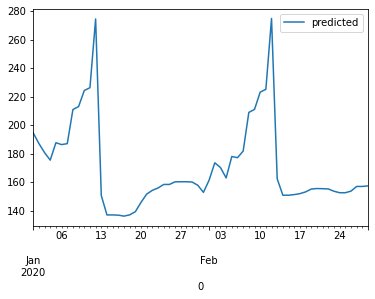

In [33]:
prediciton_set1.plot(x=0, y='predicted')
print('whole period: {}'.format(prediciton_set1['predicted'].sum()))
mask = (prediciton_set1[0] <= '2020-02-01')
print('jan: {}'.format(prediciton_set1[mask]['predicted'].sum()))
print('feb: {}'.format(prediciton_set1[~mask]['predicted'].sum()))

### Wyprzedaż: 01.02.2020 - 07.02.2020

In [34]:
prediciton_set2 = prediciton_set1.drop(['predicted'], axis=1)
prediciton_set2.loc[
    ('2020-02-01' <= prediciton_set2[0]) & (prediciton_set2[0] <= '2020-02-07'), 1
] = True
X_pred_set =  DateTransformer(0, 1).transform(prediciton_set2)
prediciton_set2['predicted'] = regressor.predict(X_pred_set)

<ipython-input-26-2ed708f2883b>:20: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['weekofyear'] = pd.DatetimeIndex(df[self.date_attr]).weekofyear


whole period: 10266.45504181004
jan: 5460.427895576646
feb: 4806.027146233398


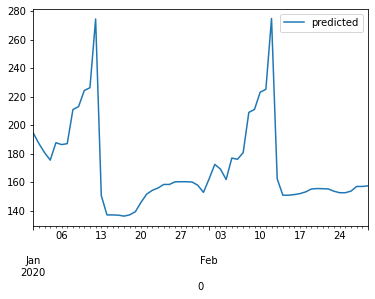

In [35]:
prediciton_set2.plot(x=0, y='predicted')
print('whole period: {}'.format(prediciton_set2['predicted'].sum()))
mask = (prediciton_set2[0] <= '2020-02-01')
print('jan: {}'.format(prediciton_set2[mask]['predicted'].sum()))
print('feb: {}'.format(prediciton_set2[~mask]['predicted'].sum()))